In [67]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-5.3.0-posix-seh-rt_v4-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

In [68]:
import pandas as pd
import numpy as np
from math import ceil

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb

In [69]:
#load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

y_target = train['TARGET']
train_id = train['ID']
test_id = test['ID']

train.shape, test.shape

((76020, 371), (75818, 370))

In [70]:
# remove columns with 0 variance
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

len(remove)

34

In [71]:
train.drop(remove, axis = 1, inplace=True)
test.drop(remove, axis = 1, inplace=True)

In [72]:
# remove duplicated columns
dup_cols = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1, len(cols)):
        if np.array_equal(v, train[cols[j]].values):
            dup_cols.append(cols[j])
            
len(dup_cols)

29

In [73]:
train.drop(dup_cols, axis=1, inplace = True)
test.drop(dup_cols, axis=1, inplace=True)

In [74]:
# Drop target and ID variables
train.drop(['TARGET', 'ID'], axis=1, inplace=True)
test.drop('ID', axis=1, inplace=True)

In [75]:
# Add feature with sum of zero values per rows

# train set
X = train.iloc[:,:]

X['no0'] = (X==0).sum(axis=1)
train['no0'] = X['no0']

# test set
X = test.iloc[:,:]
X['no0'] = (X==0).sum(axis=1)
test['no0'] = X['no0']

In [76]:
# Add feature with sum of non-zero values per rows

# train set
X = train.iloc[:,:-1]

X['no_non0'] = (X!=0).sum(axis=1)
train['no_non0'] = X['no_non0']

# test set
X = test.iloc[:,:-1]
X['no_non0'] = (X!=0).sum(axis=1)
test['no_non0'] = X['no_non0']

In [77]:
# Add feature with std per rows

# train set
X = train.iloc[:,:-2]

X['std'] = X.std(axis=1)
train['std'] = X['std']

# test set
X = test.iloc[:,:-2]
X['std'] = X.std(axis=1)
test['std'] = X['std']

In [78]:
# Add feature with mean per rows

# train set
X = train.iloc[:,:-3]

X['mean'] = X.mean(axis=1)
train['mean'] = X['mean']

# test set
X = test.iloc[:,:-2]
X['mean'] = X.mean(axis=1)
test['mean'] = X['mean']

In [79]:
train.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,no0,no_non0,std,mean
0,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,39205.170000,292,14,2241.190765,128.595327
1,2,34,0,0,0,0,0,0,0,0,...,0,0,0,0,0,49278.030000,266,40,2816.949757,168.698987
2,2,23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,67333.770000,277,29,3849.186251,220.630784
3,2,37,0,195,195,0,0,0,0,0,...,0,0,0,0,0,64007.970000,248,58,3658.826945,216.125065
4,2,39,0,0,0,0,0,0,0,0,...,0,0,0,0,0,117310.979016,256,50,24881.315402,4207.430095


In [90]:
#now I am going to calculate the zeros, and mean and std for each subset of variables
cols_imp_op = []
for col in train.columns:
    if col[0:6] == 'imp_op':
        cols_imp_op.append(col)
    
cols_ind_var = []
for col in train.columns:
    if col[0:7] == 'ind_var':
        cols_ind_var.append(col)
    
cols_num_var = []
for col in train.columns:
    if col[0:7] == 'num_var':
        cols_num_var.append(col)
    
cols_num_op = []
for col in train.columns:
    if col[0:6] == 'num_op':
        cols_num_op.append(col)

cols_saldo = []
for col in train.columns:
    if col[0:5] == 'saldo':
        cols_saldo.append(col)
        
cols_delta = []
for col in train.columns:
    if col[0:5] == 'delta':
        cols_delta.append(col)

cols_imp_aport = []
for col in train.columns:
    if col[0:9] == 'imp_aport':
        cols_imp_aport.append(col)
        
cols_imp_amort = []
for col in train.columns:
    if col[0:9] == 'imp_amort':
        cols_imp_amort.append(col)

In [93]:
# imp_op
train['imp_op_mean'] = train[cols_imp_op].mean(axis=1)
train['imp_op_std'] = train[cols_imp_op].std(axis=1)
train['imp_op_sum'] = train[cols_imp_op].sum(axis=1)
train['imp_op_zero'] = (train[cols_imp_op]==0).sum(axis=1)
train['imp_op_nonZero'] = (train[cols_imp_op]!=0).sum(axis=1)
# ind_var
train['ind_var_mean'] = train[cols_ind_var].mean(axis=1)
train['ind_var_std'] = train[cols_ind_var].std(axis=1)
train['ind_var_sum'] = train[cols_ind_var].sum(axis=1)
train['ind_var_zero'] = (train[cols_ind_var]==0).sum(axis=1)
train['ind_var_nonZero'] = (train[cols_ind_var]!=0).sum(axis=1)
#num_var
train['num_var_mean'] = train[cols_num_var].mean(axis=1)
train['num_var_std'] = train[cols_num_var].std(axis=1)
train['num_var_sum'] = train[cols_num_var].sum(axis=1)
train['num_var_zero'] = (train[cols_num_var]==0).sum(axis=1)
train['num_var_nonZero'] = (train[cols_num_var]!=0).sum(axis=1)
#num_op
train['num_op_mean'] = train[cols_num_op].mean(axis=1)
train['num_op_std'] = train[cols_num_op].std(axis=1)
train['num_op_sum'] = train[cols_num_op].sum(axis=1)
train['num_op_zero'] = (train[cols_num_op]==0).sum(axis=1)
train['num_op_nonZero'] = (train[cols_num_op]!=0).sum(axis=1)
#saldo
train['saldo_mean'] = train[cols_saldo].mean(axis=1)
train['saldo_std'] = train[cols_saldo].std(axis=1)
train['saldo_sum'] = train[cols_saldo].sum(axis=1)
train['saldo_zero'] = (train[cols_saldo]==0).sum(axis=1)
train['saldo_nonZero'] = (train[cols_saldo]!=0).sum(axis=1)

#delta
train['delta_mean'] = train[cols_delta].mean(axis=1)
train['delta_std'] = train[cols_delta].std(axis=1)
train['delta_sum'] = train[cols_delta].sum(axis=1)
train['delta_zero'] = (train[cols_delta]==0).sum(axis=1)
train['delta_nonZero'] = (train[cols_delta]!=0).sum(axis=1)
#imp_aport
train['imp_aport_mean'] = train[cols_imp_aport].mean(axis=1)
train['imp_aport_std'] = train[cols_imp_aport].std(axis=1)
train['imp_aport_sum'] = train[cols_imp_aport].sum(axis=1)
train['imp_aport_zero'] = (train[cols_imp_aport]==0).sum(axis=1)
train['imp_aport_nonZero'] = (train[cols_imp_aport]!=0).sum(axis=1)
#imp_amort
train['imp_amort_mean'] = train[cols_imp_amort].mean(axis=1)
train['imp_amort_std'] = train[cols_imp_amort].std(axis=1)
train['imp_amort_sum'] = train[cols_imp_amort].sum(axis=1)
train['imp_amort_zero'] = (train[cols_imp_amort]==0).sum(axis=1)
train['imp_amort_nonZero'] = (train[cols_imp_amort]!=0).sum(axis=1)

In [94]:
# imp_op
test['imp_op_mean'] = test[cols_imp_op].mean(axis=1)
test['imp_op_std'] = test[cols_imp_op].std(axis=1)
test['imp_op_sum'] = test[cols_imp_op].sum(axis=1)
test['imp_op_zero'] = (test[cols_imp_op]==0).sum(axis=1)
test['imp_op_nonZero'] = (test[cols_imp_op]!=0).sum(axis=1)
# ind_var
test['ind_var_mean'] = test[cols_ind_var].mean(axis=1)
test['ind_var_std'] = test[cols_ind_var].std(axis=1)
test['ind_var_sum'] = test[cols_ind_var].sum(axis=1)
test['ind_var_zero'] = (test[cols_ind_var]==0).sum(axis=1)
test['ind_var_nonZero'] = (test[cols_ind_var]!=0).sum(axis=1)
#num_var
test['num_var_mean'] = test[cols_num_var].mean(axis=1)
test['num_var_std'] = test[cols_num_var].std(axis=1)
test['num_var_sum'] = test[cols_num_var].sum(axis=1)
test['num_var_zero'] = (test[cols_num_var]==0).sum(axis=1)
test['num_var_nonZero'] = (test[cols_num_var]!=0).sum(axis=1)
#num_op
test['num_op_mean'] = test[cols_num_op].mean(axis=1)
test['num_op_std'] = test[cols_num_op].std(axis=1)
test['num_op_sum'] = test[cols_num_op].sum(axis=1)
test['num_op_zero'] = (test[cols_num_op]==0).sum(axis=1)
test['num_op_nonZero'] = (test[cols_num_op]!=0).sum(axis=1)
#saldo
test['saldo_mean'] = test[cols_saldo].mean(axis=1)
test['saldo_std'] = test[cols_saldo].std(axis=1)
test['saldo_sum'] = test[cols_saldo].sum(axis=1)
test['saldo_zero'] = (test[cols_saldo]==0).sum(axis=1)
test['saldo_nonZero'] = (test[cols_saldo]!=0).sum(axis=1)
#delta
test['delta_mean'] = test[cols_delta].mean(axis=1)
test['delta_std'] = test[cols_delta].std(axis=1)
test['delta_sum'] = test[cols_delta].sum(axis=1)
test['delta_zero'] = (test[cols_delta]==0).sum(axis=1)
test['delta_nonZero'] = (test[cols_delta]!=0).sum(axis=1)
#imp_aport
test['imp_aport_mean'] = test[cols_imp_aport].mean(axis=1)
test['imp_aport_std'] = test[cols_imp_aport].std(axis=1)
test['imp_aport_sum'] = test[cols_imp_aport].sum(axis=1)
test['imp_aport_zero'] = (test[cols_imp_aport]==0).sum(axis=1)
test['imp_aport_nonZero'] = (test[cols_imp_aport]!=0).sum(axis=1)
#imp_amort
test['imp_amort_mean'] = test[cols_imp_amort].mean(axis=1)
test['imp_amort_std'] = test[cols_imp_amort].std(axis=1)
test['imp_amort_sum'] = test[cols_imp_amort].sum(axis=1)
test['imp_amort_zero'] = (test[cols_imp_amort]==0).sum(axis=1)
test['imp_amort_nonZero'] = (test[cols_imp_amort]!=0).sum(axis=1)

In [95]:
train.shape, test.shape

((76020, 350), (75818, 350))

In [96]:
train.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,imp_aport_mean,imp_aport_std,imp_aport_sum,imp_aport_zero,imp_aport_nonZero,imp_amort_mean,imp_amort_std,imp_amort_sum,imp_amort_zero,imp_amort_nonZero
0,2,23,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,11,1,0,0,0,7,1
1,2,34,0,0,0,0,0,0,0,0,...,33.333333,94.280904,427.614237,7,5,0,0,0,7,1
2,2,23,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,11,1,0,0,0,7,1
3,2,37,0,195,195,0,0,0,0,0,...,0.000000,0.000000,0.000000,11,1,0,0,0,7,1
4,2,39,0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,11,1,0,0,0,7,1


In [85]:
train.to_csv("train_clean-newFeat.csv", index=False)
test.to_csv("test_clean_newFeat.csv", index=False)

In [97]:
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(train, y_target, test_size=0.5, random_state=290977)

In [98]:
## Feature selection
clf = ExtraTreesClassifier(random_state=1729)
selector = clf.fit(X_train, y_train)

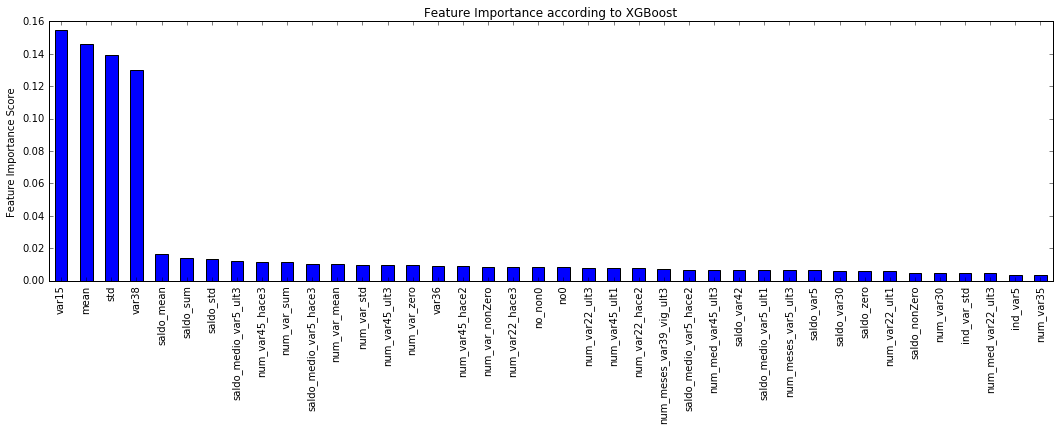

In [99]:
# plot most important features
feat_imp = pd.Series(clf.feature_importances_, index = X_train.columns.values)
feat_imp = feat_imp.sort_values(ascending=False)
feat_imp[:40].plot(kind='bar', title = 'Feature Importance according to XGBoost')
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom = 0.3)

fig = plt.gcf()
fig.set_size_inches(18, 6)

In [100]:
feat_imp.head(15)

var15                     0.154422
mean                      0.146217
std                       0.139141
var38                     0.130254
saldo_mean                0.016574
saldo_sum                 0.014009
saldo_std                 0.013007
saldo_medio_var5_ult3     0.011986
num_var45_hace3           0.011322
num_var_sum               0.011159
saldo_medio_var5_hace3    0.010503
num_var_mean              0.010118
num_var_std               0.009871
num_var45_ult3            0.009672
num_var_zero              0.009394
dtype: float64

In [101]:
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test_sm = fs.transform(test)

In [102]:
X_train.shape, X_test.shape, test.shape

((38010, 42), (38010, 42), (75818, 350))

In [103]:
## Train Model

# generate sparse matrices
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

dtest_sub = xgb.DMatrix(test_sm)

# do crossvalidation
print ('running cross validation')
param = {'max_depth':4, 'eta':1, 'silent':0, 'objective':'binary:logistic'}
num_round = 10

model_cv = xgb.cv(param, dtrain, num_round, nfold = 5,  metrics={'auc'}, seed = 0)
print(model_cv.T.T)
bestIter = model_cv.T.loc['test-auc-mean'].idxmax()
print("Best Interaction: ", bestIter)
print('=======================')
print ('building model and testing on test set')
watchlist  = [(dtest,'eval'), (dtrain,'train')]
num_round = ceil(int(bestIter) * 1.5)

xgb_model = xgb.train(param, dtrain, num_round, watchlist)
prediction = xgb_model.predict(dtest)
print('Best Inter: ', xgb_model.best_iteration)
print("Roc AUC test: ", roc_auc_score(y_test, prediction, average='macro'))

running cross validation
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.792051      0.016397        0.810669       0.003115
1       0.807958      0.010480        0.828081       0.003626
2       0.819663      0.013707        0.840960       0.003157
3       0.822131      0.011919        0.847140       0.001734
4       0.822213      0.011974        0.853165       0.002649
5       0.820427      0.013581        0.859009       0.002464
6       0.819562      0.013085        0.862202       0.002910
7       0.817737      0.012272        0.865614       0.002821
8       0.816421      0.012304        0.870027       0.001990
9       0.811801      0.013096        0.873627       0.002700
Best Interaction:  4
building model and testing on test set
[0]	eval-error:0.039490	train-error:0.039726
[1]	eval-error:0.039437	train-error:0.039542
[2]	eval-error:0.039411	train-error:0.039647
[3]	eval-error:0.039437	train-error:0.039621
[4]	eval-error:0.039437	train-error:0.039490
[5]	eval

In [104]:
# do crossvalidation
print ('running cross validation')
seed_set = 0
param = {'max_depth':2, 'eta': 0.6, 'gamma':10, 'min_child_weight': 1, 'subsample':1, 'lambda': 10, 'alpha':0.3,
             'silent':1, 'objective':'binary:logistic', 'seed': seed_set}
num_round = 40

model_cv = xgb.cv(param, dtrain, num_round, nfold = 5,  metrics={'auc'})
print(model_cv.T.T)
bestIter = model_cv.T.loc['test-auc-mean'].idxmax()
print("Best Interaction: ", bestIter)
print('=======================')
print ('building model and testing on test set')
watchlist  = [(dtest,'eval'), (dtrain,'train')]
num_round = ceil(int(bestIter) * 1.5)

# average the predictions of 10 xgboosts on different seedds
prediction = np.zeros(X_test.shape[0])
for seed_set in [1,2,3,4,5,6,7,8,9,10]:
    xgb_extraTreesParam = xgb.train(param, dtrain, num_round, watchlist)
    prediction = prediction + xgb_extraTreesParam.predict(dtest)
    i = i + 10

prediction = prediction/10
print("Roc AUC test: ", roc_auc_score(y_test, prediction, average='macro'))

running cross validation
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.720463      0.019804        0.722324       0.004688
1        0.725309      0.019262        0.729513       0.004240
2        0.780418      0.019731        0.785345       0.004746
3        0.792201      0.012995        0.800363       0.006080
4        0.798170      0.012265        0.809289       0.006084
5        0.808231      0.009637        0.818187       0.004495
6        0.813055      0.010840        0.824765       0.003471
7        0.817450      0.009499        0.829266       0.002931
8        0.819505      0.009474        0.832331       0.003139
9        0.821567      0.009136        0.835004       0.003505
10       0.823704      0.010086        0.836577       0.002811
11       0.825333      0.010545        0.837811       0.002193
12       0.825002      0.009974        0.838752       0.003024
13       0.825130      0.010043        0.838866       0.002954
14       0.825130      0.01004

In [105]:
# Save predictions on X_test for model stacking
#prediction = xgb_extraTreesParam.predict(dtest)
submission = pd.DataFrame({"TARGET": prediction})
submission.to_csv("test_xgb_ExtraTreesFeat_newFeat2.csv", index=False)

In [106]:
prediction = np.zeros(test.shape[0])
for seed_set in [1,2,3,4,5,6,7,8,9,10]:
    xgb_extraTreesParam = xgb.train(param, dtrain, num_round, watchlist)
    prediction = prediction + xgb_extraTreesParam.predict(dtest_sub)
    i = i + 10

prediction = prediction/10
#prediction = xgb_extraTreesParam.predict(dtest_sub)
submission = pd.DataFrame({"ID":test_id, "TARGET": prediction})
submission.to_csv("submission_xgb_ExtraTreesFeat_newFeat2.csv", index=False)

[0]	eval-error:0.039358	train-error:0.039779
[1]	eval-error:0.039358	train-error:0.039779
[2]	eval-error:0.039358	train-error:0.039779
[3]	eval-error:0.039358	train-error:0.039779
[4]	eval-error:0.039358	train-error:0.039779
[5]	eval-error:0.039358	train-error:0.039779
[6]	eval-error:0.039358	train-error:0.039779
[7]	eval-error:0.039358	train-error:0.039779
[8]	eval-error:0.039358	train-error:0.039779
[9]	eval-error:0.039358	train-error:0.039779
[10]	eval-error:0.039358	train-error:0.039779
[11]	eval-error:0.039358	train-error:0.039779
[12]	eval-error:0.039358	train-error:0.039779
[13]	eval-error:0.039358	train-error:0.039779
[14]	eval-error:0.039358	train-error:0.039779
[15]	eval-error:0.039358	train-error:0.039779
[16]	eval-error:0.039358	train-error:0.039779
[0]	eval-error:0.039358	train-error:0.039779
[1]	eval-error:0.039358	train-error:0.039779
[2]	eval-error:0.039358	train-error:0.039779
[3]	eval-error:0.039358	train-error:0.039779
[4]	eval-error:0.039358	train-error:0.039779
[5]

In [107]:
vars_to_keep = train.columns[-44:]
vars_to_keep

Index(['no0', 'no_non0', 'std', 'mean', 'imp_op_mean', 'imp_op_std',
       'imp_op_sum', 'imp_op_zero', 'imp_op_nonZero', 'ind_var_mean',
       'ind_var_std', 'ind_var_sum', 'ind_var_zero', 'ind_var_nonZero',
       'num_var_mean', 'num_var_std', 'num_var_sum', 'num_var_zero',
       'num_var_nonZero', 'num_op_mean', 'num_op_std', 'num_op_sum',
       'num_op_zero', 'num_op_nonZero', 'saldo_mean', 'saldo_std', 'saldo_sum',
       'saldo_zero', 'saldo_nonZero', 'delta_mean', 'delta_std', 'delta_sum',
       'delta_zero', 'delta_nonZero', 'imp_aport_mean', 'imp_aport_std',
       'imp_aport_sum', 'imp_aport_zero', 'imp_aport_nonZero',
       'imp_amort_mean', 'imp_amort_std', 'imp_amort_sum', 'imp_amort_zero',
       'imp_amort_nonZero'],
      dtype='object')

In [111]:
np.log(train.var38).shape, train.shape

((76020,), (76020, 351))

In [112]:
train['log38'] = np.log(train.var38)
test['log38'] = np.log(test.var38)

In [116]:
vars_to_keep = list(vars_to_keep)
vars_to_keep.append('log38')

In [118]:
train = train[vars_to_keep]
test = test[vars_to_keep]

X_train, X_test, y_train, y_test = train_test_split(train, y_target, test_size=0.5, random_state=290977)

In [119]:
# generate sparse matrices
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test, label = y_test)

dtest_sub = xgb.DMatrix(test)

# do crossvalidation
print ('running cross validation')
param = {'max_depth':4, 'eta':1, 'silent':0, 'objective':'binary:logistic'}
num_round = 10

model_cv = xgb.cv(param, dtrain, num_round, nfold = 5,  metrics={'auc'}, seed = 0)
print(model_cv.T.T)
bestIter = model_cv.T.loc['test-auc-mean'].idxmax()
print("Best Interaction: ", bestIter)
print('=======================')
print ('building model and testing on test set')
watchlist  = [(dtest,'eval'), (dtrain,'train')]
num_round = ceil(int(bestIter) * 1.5)

xgb_model = xgb.train(param, dtrain, num_round, watchlist)
prediction = xgb_model.predict(dtest)
print('Best Inter: ', xgb_model.best_iteration)
print("Roc AUC test: ", roc_auc_score(y_test, prediction, average='macro'))

running cross validation
   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.719072      0.020384        0.728851       0.006941
1       0.744804      0.018025        0.760187       0.009948
2       0.755292      0.020935        0.774636       0.006713
3       0.763342      0.016627        0.791026       0.004864
4       0.763198      0.017078        0.799222       0.004872
5       0.761065      0.018507        0.804876       0.004963
6       0.758291      0.020333        0.808778       0.004365
7       0.755991      0.020416        0.812513       0.004745
8       0.753498      0.019942        0.816631       0.004211
9       0.751218      0.020348        0.819357       0.004553
Best Interaction:  3
building model and testing on test set
[0]	eval-error:0.039463	train-error:0.039490
[1]	eval-error:0.039463	train-error:0.039490
[2]	eval-error:0.039569	train-error:0.039463
[3]	eval-error:0.039989	train-error:0.039726
[4]	eval-error:0.039832	train-error:0.039542
Best Int